## NLP Classification 
This is an initiative NLP classification that Mike and I have. We plan to automatically classfify variable names of the output from AMP. 

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
from textblob.classifiers import NaiveBayesClassifier
import nltk
import tokenize
from collections import Counter
import matplotlib.pyplot as plt
import plotly.plotly as py

## Read and process the data

In [4]:
df = pd.read_csv('C:/Users/zihao.zhang/NLP Classification/variable classification.csv')

In [5]:
df.iloc[10:20]

,Variable,Grouping 1,Grouping 2,Base vs Marketing
10,SNACKS.Digital Display Impressions,Digital,Display,Marketing
11,SNACKS - CANS.Quad Week %ACV _v3 - Drug,Distribution,Distribution,Base
12,SNACKS - CANS.Quad Week %ACV _v3 - Food,Distribution,Distribution,Base
13,SNACKS - CANS.Total FSIs,In Store,FSIs,Marketing
14,Constant.Intercept,Intercept,Intercept,Base
15,"Blue Diamond.Market Dummy v2.Atlanta, GA - Food",Intercept,Intercept,Base
16,"Blue Diamond.Market Dummy v2.Baltimore, MD/Was...",Intercept,Intercept,Base
17,Blue Diamond.Market Dummy v2.Birmingham/Montgo...,Intercept,Intercept,Base
18,"Blue Diamond.Market Dummy v2.Boise, ID - Food",Intercept,Intercept,Base
19,"Blue Diamond.Market Dummy v2.Boston, MA - Food",Intercept,Intercept,Base


### Update

Based on some initial test, I found out there are many noise in sentence that will impair the prediction power. For example, in the sentence "Blue Diamond.Market Dummy v2.Atlanta, GA - Food", the word "dummy" have all the information to predict that it is a intercept while all other words would be just noise for prediction. So it is important to clean the data first. I create a list of "stopwords" that I believe contain important information for prediction. Then our model becoming that we are looking for the key words in a sentence then make predictions based on the cleaned setence.

In specific:

1. delete all numbers
2. normalize words: lower case, punctuation, remove morphological affixes from words
3. delete all noise words. this part is actually done manually right now, might cause overfitting to specific projects. can be improved using large training data

In [6]:
import re
from stemming.porter2 import stem

# define the fucntion to clean text data
def clean(x):
    x = re.sub('[^A-Za-z]+', " ",  x.lower())
    x=x.replace('.',' ')
    stopwords=['dummi','acv','discount','volume','season','new year','christma','easter','month','thanksgiv',
               'price','promo','coupon','print','media','social','twitter','facebook','instagram','radio','competit','campaign',
               'magazin','mobil','intercept','constant','trade','display','impress','paid','search','click','dummi','base','rollback',
               'pr','memorial','digital','market','july','cost','fsi','can','bag','total','merch','ani','featur','brand',
              'general','sale','categori','actual','predict','valentin','lag','trp','tv','distribut','weight']
    querywords = x.split()
    querywords = [stem(querywords[i]) for i in np.arange(len(querywords))]
    resultwords  = [word for word in querywords if word in stopwords]
    result = ' '.join(resultwords)
    return(result) # The text to search


There are few rows that dose not have any words in the stepwords. I will delete those rows for now

In [7]:
df['Variable'] = list(map(clean,df['Variable']))
df = df[df.Variable != '']

This is a Visualization part showing the word frequency of our data after cleaning.

In [23]:
wordlist = str(list(map(clean,df['Variable']))).strip('[]').replace('\', \'',' ')
wordfreq = pd.DataFrame(Counter(wordlist.split()).most_common())
wordfreq.columns=['word','count']
wordfreq2=wordfreq[wordfreq['count']>15]

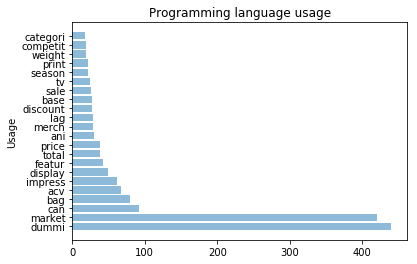

In [24]:
objects = wordfreq2.iloc[:,0]
y_pos = np.arange(len(objects))
performance = wordfreq2.iloc[:,1]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

Seperate the sample data to training data and test data

In [847]:
text = df[['Variable', 'Grouping 2']].apply(tuple, axis=1)
text = [i for i in text]
import random
index = random.sample(range(len(text)),int(len(text)*0.9))
train = [ text[i] for i in  index]
index2 = [i for i in list(range(len(text))) if i not in index]
test = [ text[i] for i in  index2]

In [848]:
train[1:20]

[('can base price', 'Base Price'),
 ('market dummi', 'Intercept'),
 ('can acv weight distribut', 'Competitive Distribution'),
 ('christma dummi', 'Seasonality'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('pr impress', 'PR'),
 ('market dummi', 'Intercept'),
 ('acv discount', 'Trade'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('market dummi', 'Intercept'),
 ('bag season', 'Seasonality'),
 ('featur', 'Trade'),
 ('acv weight distribut', 'Competitive Distribution'),
 ('market dummi', 'Intercept')]

## Model 

Naive Bayesian Classifier. The idea is based on this package: https://textblob.readthedocs.io/en/dev/classifiers.html#classifying-text

In [849]:
cl = NaiveBayesClassifier(train)

In [850]:
cl.accuracy(test)

0.8888888888888888

### Previous conclusion

The prediction accuracy is actually pretty bad, only 30%. 

Naive Bayesian is simple model, basically it is detecting the important words in each class considering their frequecy in training data. 

So in data process, we need to automatically delete those word with no information. For example, the model would predict trade when sees 2016. This should be avoid in future modeling.


### Update

From the previous modeling results, we found out the noise in variable name is the key (small training data is also a cause). So this time my main focus is to clean the noise.


88% accuracy by using the cleaned dataset. we are looking for key words in the variable names and try to predict the group name using the cleaned variable name. This actually works much better. the key in this modelling is to delete the noisy information contained in the variable name. 

In [858]:
cl.show_informative_features(10)

Most Informative Features
         contains(total) = True           Snacks : Interc =    126.0 : 1.0
         contains(dummi) = False           Trade : Interc =     83.6 : 1.0
        contains(market) = False          Season : Interc =     83.1 : 1.0
          contains(sale) = True           Catego : Trade  =     67.4 : 1.0
         contains(merch) = True           Compet : Trade  =     40.7 : 1.0
           contains(ani) = True           Compet : Trade  =     40.7 : 1.0
        contains(market) = True           Interc : Trade  =     29.4 : 1.0
           contains(bag) = True           Actual : Season =     16.0 : 1.0
      contains(categori) = False          Interc : Catego =     12.0 : 1.0
         contains(dummi) = True           Interc : Catego =     11.9 : 1.0


Let's take a look at which part the model didn't predict well. The following tuple shows the prediiton. The last column is predicted class while the second column is true class. 

In [852]:
prediction = [cl.classify(test[i][0]) for i in np.arange(len(test))]

In [853]:
[(test[i][0],test[i][1],prediction[i]) for i in  np.arange(20)]

[('can base price', 'Base Price', 'Competitive Base Price'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('can ani merch', 'Competitive Trade', 'Competitive Trade'),
 ('can', 'Trade', 'FSIs'),
 ('can display', 'Trade', 'Trade'),
 ('categori bag sale', 'Category', 'Category'),
 ('coupon', 'Digital Coupons', 'Digital Coupons'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('market dummi', 'Intercept', 'Intercept'),
 ('competit print impress', 'Competitive Media', 'Competitive Media'),
 ('total impress', 'Social Media', 'Social Media')]

In [854]:
indexwrong = [test[i][1]!=prediction[i] for i in  np.arange(len(test))]
a= np.array(index2)
a= a[indexwrong]
a= list(a)
b = np.array(np.arange(len(test)))
b = b[indexwrong]

This above shows where the model predict wrong. 

In [855]:
[(test[i][0],test[i][1],prediction[i]) for i in np.arange(len(test)) if i in b]

[('can base price', 'Base Price', 'Competitive Base Price'),
 ('can', 'Trade', 'FSIs'),
 ('total impress', 'Catalina', 'Social Media'),
 ('tv', 'Breeze TV', 'FSIs'),
 ('actual', 'Dependent', 'FSIs'),
 ('tv campaign', 'Snacks TV', 'Breeze TV'),
 ('tv campaign', 'Snacks TV', 'Breeze TV'),
 ('bag sale', 'Category', 'FSIs'),
 ('sale', 'Competition', 'Category'),
 ('impress', 'Catalina', 'Social Media')]

## Future work

With more data and more rich vocabulary into the "stopwords", I am expecting prediction results in new dataset growing to >90%. 